In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from itertools import permutations
from scipy.stats import mannwhitneyu
import seaborn as sns

<b>  <font color='blue'> READING DATA

In [2]:
data = pd.read_csv(r'C:\Users\RVSHA\Downloads\Pilot_store_SE0144.csv' , parse_dates=['sales_date'])
data['Store'] = data['Store_status'].apply(lambda x: 'T_' if x == 'Potential_twin_store' else 'P_') 
data['Store'] = data['Store'] + data['Store_ID']
data['Conv'] = round(data['No_of_receipts'] / data['No_of_vistors'],4) * 100
data['Que'] = round(data['No_of_queue_receipts'] / data['No_of_receipts'],4) * 100 
data['Mem'] = round(data['No_of_member_receipts'] / data['No_of_receipts'],4) * 100
data.rename(columns={"No_of_vistors":"Visitors", "No_of_receipts":"Orders"} , inplace = True)
data = data[['sales_date','Time_status','Store_ID','Store_status','Store','Visitors','Orders','Conv','Que','Mem']]
data.sort_values(['Store','sales_date'], ascending = [True,True],inplace =True)
data.head(6)

,sales_date,Time_status,Store_ID,Store_status,Store,Visitors,Orders,Conv,Que,Mem
0,2019-08-18,Before,SE0144,Pilot_store,P_SE0144,9226.0,2391,25.92,11.67,38.18
1,2019-08-19,Before,SE0144,Pilot_store,P_SE0144,5001.0,1325,26.49,15.47,36.38
2,2019-08-20,Before,SE0144,Pilot_store,P_SE0144,5151.0,1468,28.50,15.46,38.01
3,2019-08-21,Before,SE0144,Pilot_store,P_SE0144,4638.0,1333,28.74,15.98,40.66
4,2019-08-22,Before,SE0144,Pilot_store,P_SE0144,4703.0,1283,27.28,16.45,45.21
5,2019-08-23,Before,SE0144,Pilot_store,P_SE0144,7317.0,2122,29.00,12.96,38.31


In [3]:
data.groupby('Store')['Que'].rolling(2).mean()

Store          
P_SE0144  0           NaN
          1        13.570
          2        15.465
          3        15.720
          4        16.215
                    ...  
T_SE1001  22418    25.185
          22558    25.520
          22698    26.590
          22838    21.500
          27015       NaN
Name: Que, Length: 27430, dtype: float64

In [4]:
# data = pd.read_csv(r'C:\Users\RVSHA\Downloads\Pilot_store_FR0116.csv')
# print('Number of Stores :', data['Store_ID'].nunique())
# print('Number of Days before :', data['sales_date'].nunique())
# data.head()

<b>  <font color='blue'> REMOVING DAYS AND STORES WITH A LOT OF NULL VALUES

In [5]:
filter_df =  data[data.Time_status == 'Before'].pivot(index='Store', columns='sales_date', values='Visitors')
null_days =  filter_df.columns[filter_df.isnull().sum(axis=0) > 7].tolist()
print('\nDays with nulls : ',len(null_days))
# filter_df.drop(null_days , axis = 1 , inplace = True)
null_store = filter_df[filter_df.isnull().sum(axis=1) > 1].index.tolist()
print('Store with nulls: ',len(null_store))
data = data[~( (data['sales_date'].isin(null_days)) | (data['Store_status'].isin(null_store)) )]
data = data[ (data.Conv <= 100) | (data['Conv'].isna()) ]
before_df = data[data.Time_status == 'Before']
print('Left Number of days:', before_df['sales_date'].nunique())
print('Left Number of store:',before_df['Store'].nunique())
# data.to_csv(r'C:\Users\RVSHA\Downloads\twin_data.csv', index = False)


Days with nulls :  18
Store with nulls:  34
Left Number of days: 83
Left Number of store: 148


<b>  <font color='blue'> CHECKING DISPERSION OF KPIs (Red line is mean of Pilot store)

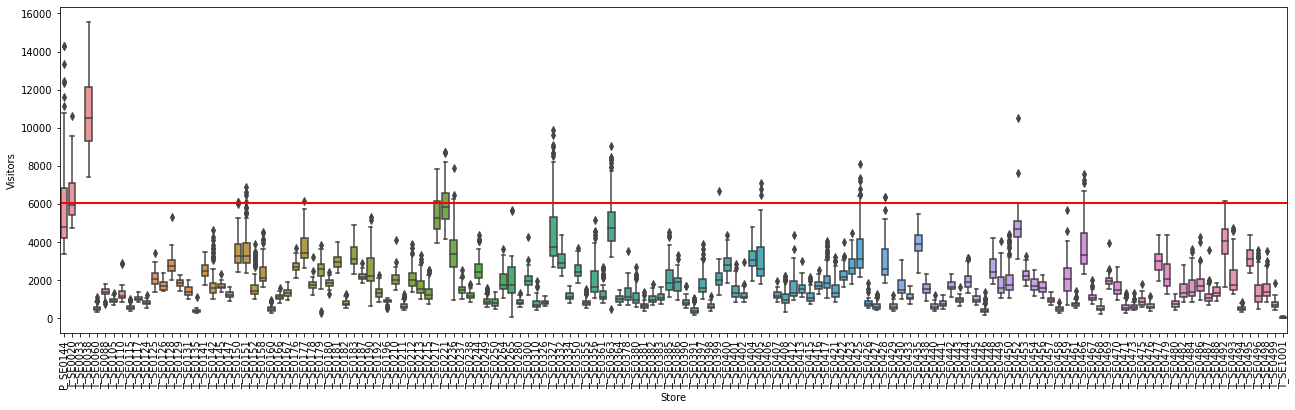

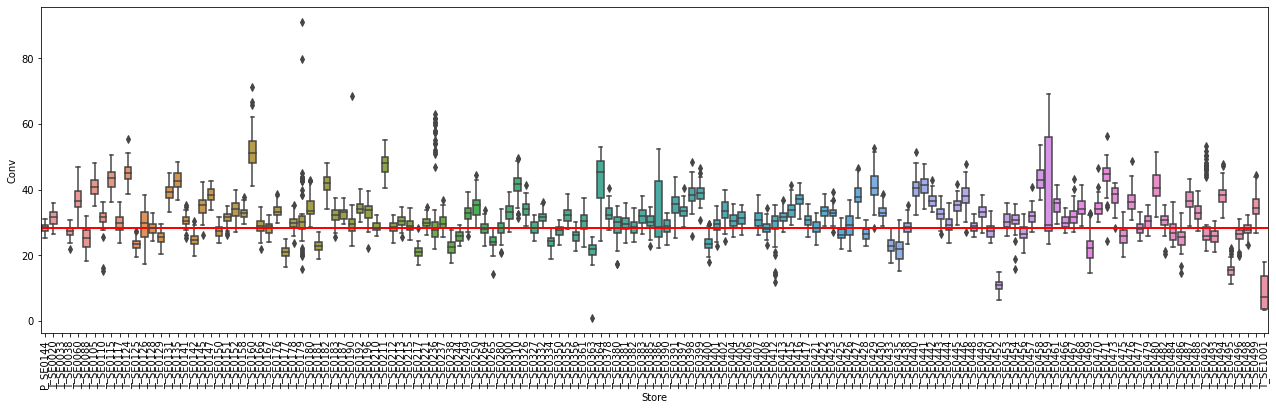

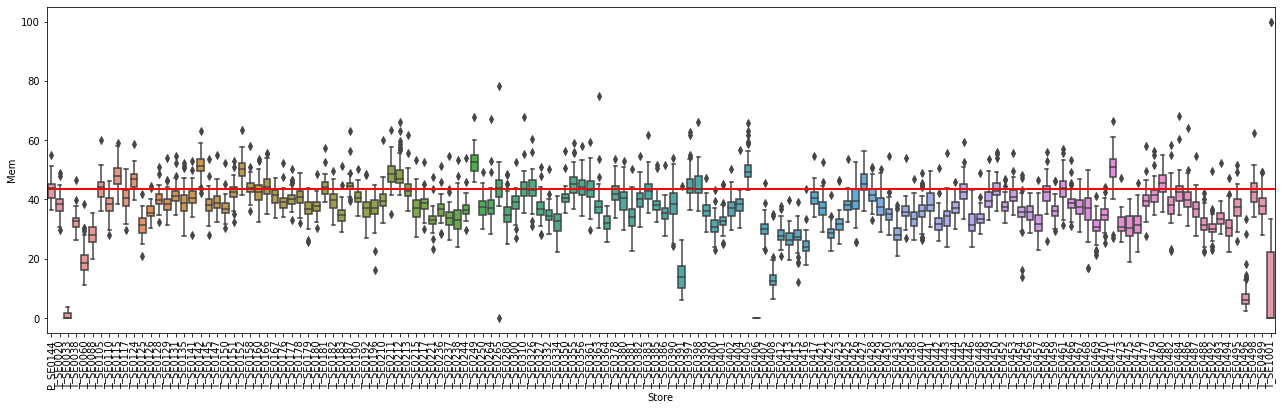

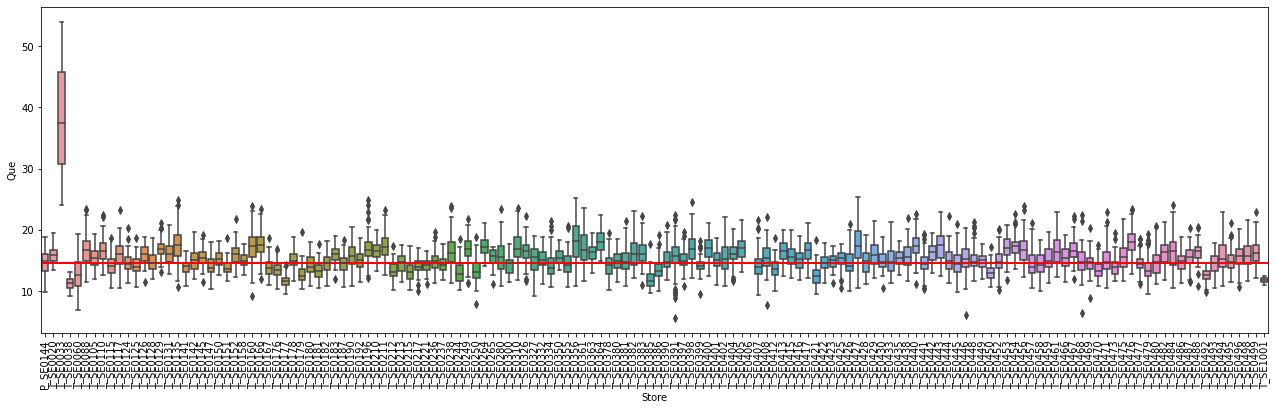

In [6]:
var = 'Visitors'
# Pilot mean for this variable
pilot_mean = np.mean(before_df[before_df.Store == 'P_SE0144'][var])
sns.boxplot(x= 'Store',y= var, data=before_df)
plt.axhline(y=pilot_mean, xmin=0, color='red', linewidth=2)
fig = plt.gcf()
fig.set_size_inches(22,6)
plt.xticks(rotation=90)
plt.show()

var = 'Conv'
# Pilot mean for this variable
pilot_mean = np.mean(before_df[before_df.Store == 'P_SE0144'][var])
sns.boxplot(x= 'Store',y= var, data=before_df)
plt.axhline(y=pilot_mean, xmin=0, color='red', linewidth=2)
fig = plt.gcf()
fig.set_size_inches(22,6)
plt.xticks(rotation=90)
plt.show()

var = 'Mem'
pilot_mean = np.mean(before_df[before_df.Store == 'P_SE0144'][var])
sns.boxplot(x= 'Store',y= var, data=before_df)
plt.axhline(y=pilot_mean, xmin=0, color='red', linewidth=2)
fig = plt.gcf()
fig.set_size_inches(22,6)
plt.xticks(rotation=90)
plt.show()

var = 'Que'
pilot_mean = np.mean(before_df[before_df.Store == 'P_SE0144'][var])
sns.boxplot(x= 'Store',y= var, data=before_df)
plt.axhline(y=pilot_mean, xmin=0, color='red', linewidth=2)
fig = plt.gcf()
fig.set_size_inches(22,6)
plt.xticks(rotation=90)
plt.show()

<b>  <font color='blue'> FUNCTION FOR SAMENESS PARAMETERS

In [7]:
def test(df):
    remove_list = ['P_SE0144','T_SE0126','T_SE0364','T_SE0380','T_SE0473','T_SE1001','T_SE0265','T_SE0033','T_SE0406']
    
    store_list = df['Store'].unique().tolist()
    #     store_list.remove('P_SE0144')
    for ele in remove_list :
        store_list.remove(ele)
    

  
    kpi_list = ['Conv','Que','Mem']
    result_df = pd.DataFrame({'Store':store_list})
    
    for kpi in kpi_list:
        boot_df = pd.DataFrame()
        p_list, twin_store, dist_list,sim_list = [],[],[],[]
        for store in store_list:
            sample1 = df[df.Store == 'P_SE0144'][kpi]
            sample2 = df[df.Store == store][kpi]
            stat, p = mannwhitneyu(sample1,sample2,alternative='two-sided')
            
            if p > 0.4:
                test = 5
            if p > 0.25:
                test = 4
            if p > 0.15:
                test = 3
            elif p > 0.1:
                test = 2
            elif p > 0.07:
                test = 1
            else:
                test = 0
            p_list.append(test)
            twin_store.append(store)
            
            kpi_df = df[df['Store'].isin(['P_SE0144',store])].pivot(index='Store', columns='sales_date', values= kpi)
            kpi_df.fillna(0, inplace= True)
            dist = pairwise_distances(kpi_df, metric='manhattan', n_jobs=1)[0,1]
            dist_list.append(dist)
            
            sim = cosine_similarity(kpi_df,dense_output=False)[0,1]
            sim_list.append(round(sim * 100,2))
            
        boot_df['Store'] = twin_store
        boot_df['test_'+ kpi] = p_list
        boot_df['dist_'+ kpi] = dist_list
        boot_df['dist_'+ kpi] = round(boot_df['dist_'+ kpi] / boot_df['dist_'+ kpi].min(),2)
        boot_df['sim_'+ kpi] = sim_list
        
        result_df = result_df.merge(boot_df , how = 'left', on = 'Store' )
        
    return result_df

twin = test(before_df).sort_values(['dist_Conv','dist_Que','dist_Mem'], ascending = [True,True,True])
twin.head(30)
# twin.to_csv(r'C:\Users\RVSHA\Downloads\similar_stores.csv', index = False)

,Store,test_Conv,dist_Conv,sim_Conv,test_Que,dist_Que,sim_Que,test_Mem,dist_Mem,sim_Mem
39,T_SE0212,3,1.00,99.87,0,2.10,98.13,0,2.09,99.64
55,T_SE0327,3,1.04,99.87,2,1.07,99.46,0,2.71,99.64
86,T_SE0421,3,1.13,99.83,0,1.99,98.85,0,2.63,99.61
10,T_SE0128,3,1.16,99.81,3,1.24,99.15,0,1.49,99.73
37,T_SE0210,3,1.16,99.85,0,1.93,98.54,0,1.73,99.66
105,T_SE0448,0,1.19,99.84,3,1.52,98.89,0,4.12,99.69
1,T_SE0038,0,1.21,99.90,0,2.71,99.36,0,4.55,99.85
50,T_SE0264,3,1.23,99.80,0,2.45,99.07,0,2.66,99.21
41,T_SE0215,0,1.25,99.83,0,1.78,98.79,0,2.72,99.36
107,T_SE0450,0,1.30,99.81,0,2.02,98.57,3,1.00,99.77


In [8]:
twin.head()

,Store,test_Conv,dist_Conv,sim_Conv,test_Que,dist_Que,sim_Que,test_Mem,dist_Mem,sim_Mem
39,T_SE0212,3,1.00,99.87,0,2.10,98.13,0,2.09,99.64
55,T_SE0327,3,1.04,99.87,2,1.07,99.46,0,2.71,99.64
86,T_SE0421,3,1.13,99.83,0,1.99,98.85,0,2.63,99.61
10,T_SE0128,3,1.16,99.81,3,1.24,99.15,0,1.49,99.73
37,T_SE0210,3,1.16,99.85,0,1.93,98.54,0,1.73,99.66


<b>  <font color='blue'> CHECKING PATTERN OF SELECTED STORE

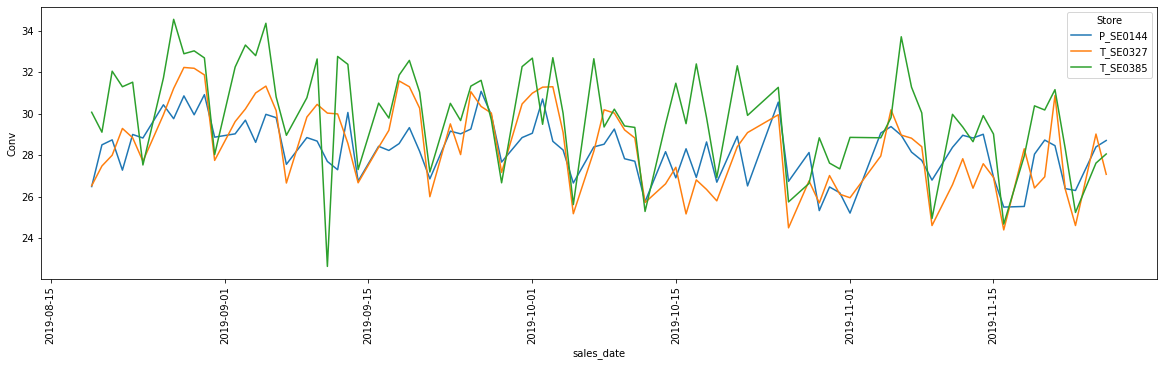

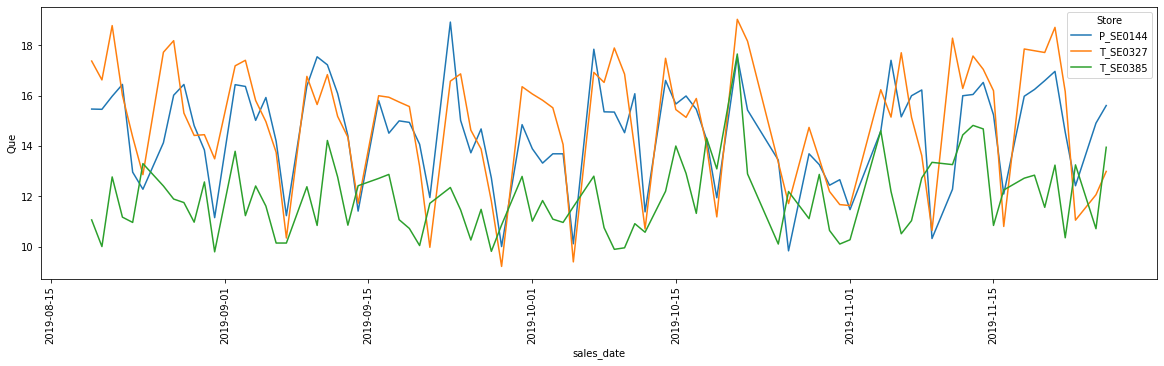

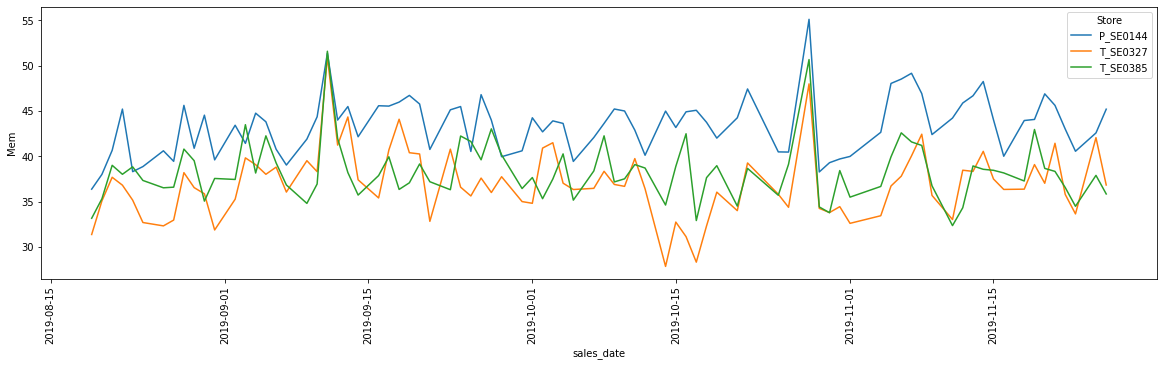

In [9]:
var = 'Conv'

plot_df = before_df[before_df['Store'].isin(['P_SE0144','T_SE0385','T_SE0327'])]

sns.lineplot(x="sales_date", y= var, data=plot_df, hue='Store')
fig = plt.gcf()
fig.set_size_inches(20,5)
plt.xticks(rotation=90)
plt.show()

var = 'Que'
sns.lineplot(x="sales_date", y= var, data=plot_df, hue='Store')
fig = plt.gcf()
fig.set_size_inches(20,5)
plt.xticks(rotation=90)
plt.show()

var = 'Mem'
sns.lineplot(x="sales_date", y= var, data=plot_df, hue='Store')
fig = plt.gcf()
fig.set_size_inches(20,5)
plt.xticks(rotation=90)
plt.show()